In [1]:
import numpy as np
import pandas as pd
import qPAI_cINN_uncertainty_estimation.config as c
import matplotlib.pyplot as plt
import pathlib
import torch
from qPAI_cINN_uncertainty_estimation.viz import save_fig
from qPAI_cINN_uncertainty_estimation.data import prepare_dataloader

CPU only


In [2]:
output_csv = c.output_dir / 'multiple_eval.csv'
df = pd.read_csv(output_csv)

     Unnamed: 0                         name partitioned_eval  sparsity_eval  \
0             0        phantom_3_partitioned             part              3   
1             1        phantom_3_partitioned             part              5   
2             2        phantom_3_partitioned             part             10   
3             3        phantom_3_partitioned             part             25   
4             4        phantom_3_partitioned             part             40   
..          ...                          ...              ...            ...   
355         355  melanin_flexi_unpartitioned           unpart              3   
356         356  melanin_flexi_unpartitioned           unpart              5   
357         357  melanin_flexi_unpartitioned           unpart             10   
358         358  melanin_flexi_unpartitioned           unpart             25   
359         359  melanin_flexi_unpartitioned           unpart             40   

     med_calib_err  calib_err_68  med_u

In [27]:
df_phantom = df[df.name.str.startswith('p')]
df_generic = df[df.name.str.startswith('g')]
df_melanin = df[df.name.str.startswith('m')]

In [28]:
df = pd.read_csv(output_csv)
df = df[df.name.str.startswith('m')]  # Phantom only
#df = df[~df.name.str.contains('flexi')]  # Non-flexi only
phantom_best_rows_part = []
for train in ['_partitioned', 'unpartitioned']:
    for eval_part in [['part'], ['unpart']]:
        for sparsity in [3, 5, 10, 25, 40]:
            row = df[(df.name.str.contains(train)) & (df.partitioned_eval.isin(eval_part)) & (df.sparsity_eval == sparsity)].sort_values(by='med_rel_err').head(1).to_dict()
            row = {key: [sub_val for sub_val in val.values()][0] for key, val in row.items()}
            phantom_best_rows_part.append(row)
df = pd.DataFrame(phantom_best_rows_part)
df['Training'] = df.name.str.split('_').str[2]
df['Evaluation'] = df.partitioned_eval
df['Sparsity'] = df.sparsity_eval
df = df.round(1)
df['Median relative error and IQR'] = df.med_rel_err.astype(str) + '% (' + df.iqr_lower.astype(str) + ', ' + df.iqr_upper.astype(str) + ')%'
df.pivot(index='Sparsity', columns=['Training', 'Evaluation'], values=['Median relative error and IQR'])

Median relative error and IQR                       \
Training                     partitioned                        
Evaluation                          part               unpart   
Sparsity                                                        
3                    24.3% (11.9, 46.8)%  29.2% (14.5, 50.8)%   
5                    21.2% (10.1, 42.9)%  25.2% (12.3, 44.6)%   
10                   23.7% (12.0, 40.1)%  24.1% (12.1, 42.4)%   
25                    20.6% (9.7, 40.8)%   21.7% (9.8, 41.7)%   
40                    18.7% (9.2, 39.9)%  22.4% (10.9, 42.3)%   

                                                      
Training          unpartitioned                       
Evaluation                 part               unpart  
Sparsity                                              
3           24.4% (11.9, 47.2)%  26.3% (12.9, 48.8)%  
5           21.7% (10.7, 42.8)%  22.8% (11.1, 44.8)%  
10          22.1% (10.5, 42.3)%  22.9% (10.8, 42.8)%  
25          21.4% (10.6, 39.3)%  21.6% (10.2, 42.2)%  
40           19.2% (8.9, 40.4)%   18.9% (8.8, 38.9)%

In [29]:
df = pd.read_csv(output_csv)
dataset = 'melanin'
df = df[df.name.str.startswith(dataset)]
best_rows_flexi = []
best_rows_specific = []

for sparsity in [3, 5, 10, 25, 40]:
    flexi_row = df[(df.name.str.contains('flexi')) & (df.sparsity_eval == sparsity)].sort_values(by='med_rel_err').head(1).to_dict()
    flexi_row = {key: [sub_val for sub_val in val.values()][0] for key, val in flexi_row.items()}
    specific_row = df[(~df.name.str.contains('flexi')) & (df.sparsity_eval == sparsity)].sort_values(by='med_rel_err').head(1).to_dict()
    specific_row = {key: [sub_val for sub_val in val.values()][0] for key, val in specific_row.items()}
    best_rows_flexi.append(flexi_row)
    best_rows_specific.append(specific_row)

flexi_df = pd.DataFrame(best_rows_flexi)
specific_df = pd.DataFrame(best_rows_specific)
flexi_df

,Unnamed: 0,name,partitioned_eval,sparsity_eval,med_calib_err,calib_err_68,med_uncert_68,med_rel_err,iqr_lower,iqr_upper
0,265,melanin_flexi_unpartitioned,part,3,0.078260,0.118696,0.616189,30.324149,16.190648,45.078677
1,266,melanin_flexi_unpartitioned,part,5,0.089149,0.138483,0.595568,28.610058,15.235889,42.091568
2,267,melanin_flexi_unpartitioned,part,10,0.125335,0.155587,0.580482,23.935082,11.753157,40.703460
3,358,melanin_flexi_unpartitioned,unpart,25,0.135298,0.150154,0.527338,21.626421,10.229479,42.162377
4,269,melanin_flexi_unpartitioned,part,40,0.131697,0.154916,0.491042,21.550336,9.979278,41.704366


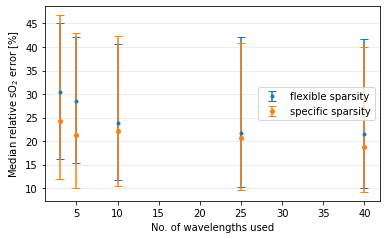

In [30]:
def get_relative_iqrs(name, df):
    return np.vstack((df[name] - df["iqr_lower"], df["iqr_upper"] - df[name]))

fig, ax = plt.subplots()
fig.subplots_adjust(top=0.8)
#ax.set_xlim(0, 100)
#ax.set_ylim(0, 100)
ax.set_ylabel(f"Median relative sO$_2$ error [%]")
ax.set_xlabel("No. of wavelengths used")
x = flexi_df['sparsity_eval']
y = flexi_df['med_rel_err']
#ax.plot(np.arange(0, 100), np.arange(0, 100), color='k', linestyle='-', linewidth=2, zorder=100)
ax.errorbar(
    x, y,
    yerr=get_relative_iqrs('med_rel_err', flexi_df),
    label='flexible sparsity',
    #elinewidth=0.1,
    capsize=4,
    #ecolor='r',
    #errorevery=10,
    #markevery=10,
    #ls='none',
    ms=3,
    fmt='o',
)

x = specific_df['sparsity_eval']
y = specific_df['med_rel_err']
ax.errorbar(
    x, y,
    yerr=get_relative_iqrs('med_rel_err', specific_df),
    label='specific sparsity',
    #elinewidth=0.1,
    capsize=4,
    #ecolor='r',
    #errorevery=10,
    #markevery=10,
    #ls='none',
    ms=4,
    fmt='o',
)
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
ax.legend()
#ax.set_title(f"{measure_str} sO2 predictions of cINN based on 1000 samples")
#save_fig(c.output_dir, f"flexi_specific_{dataset}.png")

In [48]:
training_dataloader = prepare_dataloader(c.data_path, 'FlowPhantom_insilico_complicated', 'training', [40], 1)
labels = []
for data, label in iter(training_dataloader):
    labels.append(np.array(label[0][0]))

[tensor([[0.9895, 0.9895]]),
 tensor([[0.8111, 0.8111]]),
 tensor([[0.6818, 0.6818]]),
 tensor([[0.4985, 0.4985]]),
 tensor([[0.4380, 0.4380]]),
 tensor([[0.8096, 0.8096]]),
 tensor([[0.8786, 0.8786]]),
 tensor([[0.1197, 0.1197]]),
 tensor([[0.2165, 0.2165]]),
 tensor([[0.4983, 0.4983]]),
 tensor([[0.6925, 0.6925]]),
 tensor([[0.6708, 0.6708]]),
 tensor([[0.3425, 0.3425]]),
 tensor([[0.9476, 0.9476]]),
 tensor([[0.7010, 0.7010]]),
 tensor([[0.0928, 0.0928]]),
 tensor([[0.8208, 0.8208]]),
 tensor([[0.3248, 0.3248]]),
 tensor([[0.7369, 0.7369]]),
 tensor([[0.7256, 0.7256]]),
 tensor([[0.0547, 0.0547]]),
 tensor([[0.9918, 0.9918]]),
 tensor([[0.0960, 0.0960]]),
 tensor([[0.6793, 0.6793]]),
 tensor([[0.7256, 0.7256]]),
 tensor([[0.4107, 0.4107]]),
 tensor([[0.5475, 0.5475]]),
 tensor([[0.9757, 0.9757]]),
 tensor([[0.5629, 0.5629]]),
 tensor([[0.5907, 0.5907]]),
 tensor([[0.3703, 0.3703]]),
 tensor([[0.8594, 0.8594]]),
 tensor([[0.5907, 0.5907]]),
 tensor([[0.1824, 0.1824]]),
 tensor([[0.30

(array([11836., 12994., 13779., 14979., 13216., 11522., 12729., 14103.,
        16680., 12786.]),
 array([0.00230804, 0.10197053, 0.20163302, 0.3012955 , 0.40095797,
        0.5006205 , 0.60028297, 0.69994545, 0.79960793, 0.8992704 ,
        0.9989329 ], dtype=float32),
 <BarContainer object of 10 artists>)

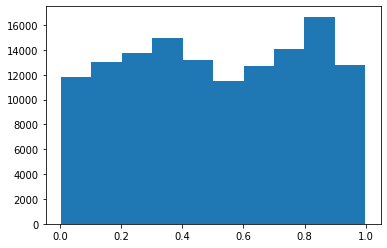

In [54]:
plt.hist(labels)

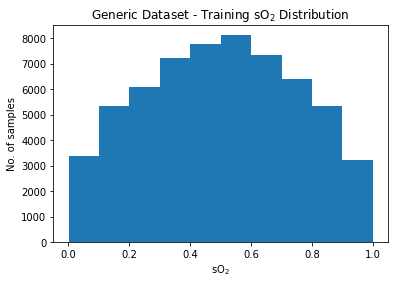

In [2]:
training_dataloader = prepare_dataloader(pathlib.Path(r'I:\research\seblab\data\group_folders\Kevin\PartIII_Kevin_Gu\Datasets'), 'NoSkin_filtered', 'filtered_training', [40], 1)
labels = []
for data, label in iter(training_dataloader):
    labels.append(np.array(label[0][0]))
fig, ax = plt.subplots()
ax.hist(labels)
ax.set_xlabel('sO$_2$')
ax.set_ylabel('No. of samples')
ax.set_title('Generic Dataset - Training sO$_2$ Distribution')
plt.show()

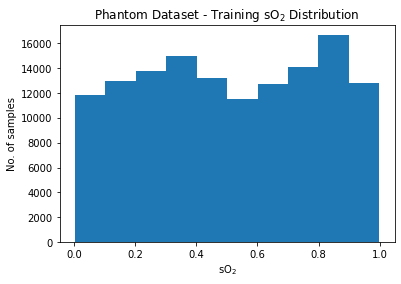

In [65]:
training_dataloader = prepare_dataloader(pathlib.Path(r'I:\research\seblab\data\group_folders\Kevin\PartIII_Kevin_Gu\Datasets'), 'FlowPhantom_insilico_complicated', 'training', [40], 1)
labels = []
for data, label in iter(training_dataloader):
    labels.append(np.array(label[0][0]))

fig, ax = plt.subplots()
ax.hist(labels)
ax.set_xlabel('sO$_2$')
ax.set_ylabel('No. of samples')
ax.set_title('Phantom Dataset - Training sO$_2$ Distribution')
plt.show()

In [ ]:
training_dataloader, dataset = prepare_dataloader(pathlib.Path(r'I:\research\seblab\data\group_folders\Kevin\PartIII_Kevin_Gu\Datasets'), 'NoSkin_filtered', 'filtered_training', [40], 1)
labels = []
for data, label in iter(training_dataloader):
    labels.append(np.array(label[0][0]))

In [ ]:
labels = []
for data, label in iter(dataset):
    labels.append(np.array(label[0]))

hist, _ = np.histogram(labels)
weights = 1 / hist

In [27]:
for label in labels:
    print(label)
    print(weights[int(np.floor(label*10))])

0.44916773
0.0001288659793814433
0.45901927
0.0001288659793814433
0.3880873
0.00013871549452073797
0.4257205
0.0001288659793814433
0.3573939
0.00013871549452073797
0.48382965
0.0001288659793814433
0.4065785
0.0001288659793814433
0.37790787
0.00013871549452073797
0.45938033
0.0001288659793814433
0.48382965
0.0001288659793814433
0.48382965
0.0001288659793814433
0.34844103
0.00013871549452073797
0.35919023
0.00013871549452073797
0.35174674
0.00013871549452073797
0.48382965
0.0001288659793814433
0.48382965
0.0001288659793814433
0.4533501
0.0001288659793814433
0.48382965
0.0001288659793814433
0.38423052
0.00013871549452073797
0.36706564
0.00013871549452073797
0.38359937
0.00013871549452073797
0.36361727
0.00013871549452073797
0.4244821
0.0001288659793814433
0.44528362
0.0001288659793814433
0.5079302
0.00012312238364934746
0.5079302
0.00012312238364934746
0.5079302
0.00012312238364934746
0.5079302
0.00012312238364934746
0.47355226
0.0001288659793814433
0.5079302
0.00012312238364934746
0.4397

In [28]:
samples_weight = np.array([weights[int(np.floor(label*10))] for label in labels])
samples_weight = torch.from_numpy(samples_weight)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))
print(samples_weight)

tensor([0.0001, 0.0001, 0.0001,  ..., 0.0001, 0.0001, 0.0001],
       dtype=torch.float64)


In [30]:
training_dataloader, dataset = prepare_dataloader(pathlib.Path(r'I:\research\seblab\data\group_folders\Kevin\PartIII_Kevin_Gu\Datasets'), 'NoSkin_filtered', 'filtered_training', [40], 1, sampler=sampler)
labels = []
for data, label in iter(training_dataloader):
    labels.append(np.array(label[0][0]))

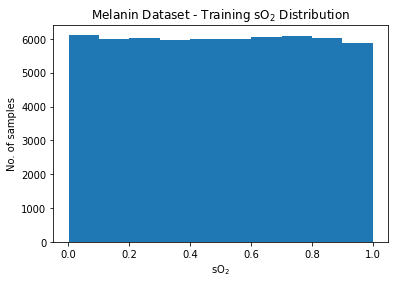

In [31]:
fig, ax = plt.subplots()
ax.hist(labels)
ax.set_xlabel('sO$_2$')
ax.set_ylabel('No. of samples')
ax.set_title('Melanin Dataset - Training sO$_2$ Distribution')
plt.show()

     Unnamed: 0                         name partitioned_eval  sparsity_eval  \
0             0        phantom_3_partitioned             part              3   
1             1        phantom_3_partitioned             part              5   
2             2        phantom_3_partitioned             part             10   
3             3        phantom_3_partitioned             part             25   
4             4        phantom_3_partitioned             part             40   
..          ...                          ...              ...            ...   
355         355  melanin_flexi_unpartitioned           unpart              3   
356         356  melanin_flexi_unpartitioned           unpart              5   
357         357  melanin_flexi_unpartitioned           unpart             10   
358         358  melanin_flexi_unpartitioned           unpart             25   
359         359  melanin_flexi_unpartitioned           unpart             40   

     med_calib_err  calib_err_68  med_u

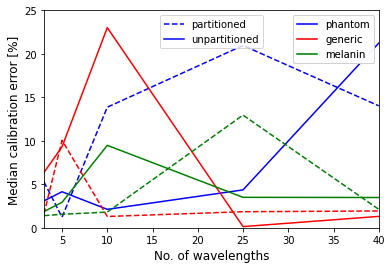

In [93]:
import itertools
df = pd.read_csv(output_csv)
fig, ax = plt.subplots()
datasets = ['phantom', 'generic', 'melanin']
colors = ['b', 'r', 'g', 'c']
cc = itertools.cycle(colors)
print(df)
for dataset in datasets:
    df = pd.read_csv(output_csv)
    print(dataset)
    root_df = df[df.name.str.startswith(dataset)]
    part_rows = []
    for part in 'part', 'unpart':
        rows = []
        for n_str, n in {'3': 3, '5': 5, '10': 10, '25': 25, '40': 40}.items():
            df = root_df[root_df.name.str.contains(f'_{n_str}')]
            df = df[df['sparsity_eval']==n]
            df = df[df.name.str.contains(f'_{part}') & df.partitioned_eval.str.fullmatch(part)]
            rows.append(df.head(1))
        part_rows.append(rows)
    part_df = pd.concat(part_rows[0])
    unpart_df = pd.concat(part_rows[1])
    print(part_df)
    c = next(cc)
    ax.plot(part_df['sparsity_eval'], part_df['med_calib_err']*100, linestyle='--', label='partitioned', color=c)
    ax.plot(unpart_df['sparsity_eval'], unpart_df['med_calib_err']*100, label='unpartitioned', color=c)

lines = ax.get_lines()
print(lines)
legend1 = plt.legend([lines[i] for i in [0,1]], ["partitioned", "unpartitioned"], loc=9)
legend2 = plt.legend([lines[i] for i in [1,3,5]], datasets, loc=1)
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_xlabel('No. of wavelengths', fontsize=12)
ax.set_ylabel('Median calibration error [%]', fontsize=12)
#ax.legend(fontsize=12)
ax.set_xlim(3,40)
ax.set_ylim(0,25)
#ax.set_title('Melanin Dataset - Training sO$_2$ Distribution')
plt.show()